In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 33.0 MB/s eta 0:00:00


In [5]:
import os
import time
import numpy as np
import rasterio
from rasterio.warp import transform_bounds
import ee
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from datetime import datetime

# Configuration for Durula Dubi village, Morigaon district, Assam
EE_PROJECT = 'alpha-earth-473414'
YEAR_LABEL = '2018'  # You can modify this for different years (2017-2024)
START_DATE = '2018-01-01'
END_DATE = '2019-01-01'
EXPORT_FOLDER = 'flood_predictions_durula_dubi_assam'
SCALE_METERS = 10
MAXPIXELS = 1e13
POLL_INTERVAL = 8

# Durula Dubi village coordinates and area definition
DURULA_DUBI_LAT = 26.178
DURULA_DUBI_LON = 92.353

# Define buffer size around the village
# Options: 0.01 (~2.2km), 0.02 (~4.4km), 0.025 (~5.5km), 0.03 (~6.6km), 0.04 (~8.8km), 0.05 (~11km)
BUFFER_DEGREES = 0.025  # Approximately 5.5km x 5.5km study area
AREA_BOUNDS = {
    'west': DURULA_DUBI_LON - BUFFER_DEGREES,
    'south': DURULA_DUBI_LAT - BUFFER_DEGREES,
    'east': DURULA_DUBI_LON + BUFFER_DEGREES,
    'north': DURULA_DUBI_LAT + BUFFER_DEGREES
}

def initialize_earth_engine():
    """Initialize Google Earth Engine"""
    print("🚀 Starting Google Earth Engine Embedding Download for Durula Dubi Village")
    print("📍 Location: Durula Dubi, Morigaon District, Assam, India")
    print(f"🎯 Coordinates: {DURULA_DUBI_LAT}°N, {DURULA_DUBI_LON}°E")
    print("=" * 80)

    try:
        ee.Authenticate()
    except:
        print("Authentication may have failed, but continuing...")

    try:
        ee.Initialize(project=EE_PROJECT)
        print("✅ Earth Engine initialized successfully")
        return True
    except Exception as e:
        print(f"❌ Earth Engine initialization failed: {e}")
        return False

def get_durula_dubi_bounds():
    """Get the bounds for Durula Dubi village area"""
    print(f"📍 Setting up study area around Durula Dubi village")

    west = AREA_BOUNDS['west']
    south = AREA_BOUNDS['south']
    east = AREA_BOUNDS['east']
    north = AREA_BOUNDS['north']

    # Calculate approximate dimensions
    lat_distance = (north - south) * 111.32  # km (1 degree lat ≈ 111.32 km)
    lon_distance = (east - west) * 111.32 * np.cos(np.radians(DURULA_DUBI_LAT))  # km

    print(f"   🗺️  Study area bounds:")
    print(f"      West: {west:.6f}°")
    print(f"      South: {south:.6f}°")
    print(f"      East: {east:.6f}°")
    print(f"      North: {north:.6f}°")
    print(f"   📏 Approximate dimensions: {lat_distance:.2f}km x {lon_distance:.2f}km")
    print(f"   🏞️  Area: {lat_distance * lon_distance:.2f} km²")

    return {
        'bounds_wgs84': (west, south, east, north),
        'center_lat': DURULA_DUBI_LAT,
        'center_lon': DURULA_DUBI_LON,
        'area_km2': lat_distance * lon_distance
    }

def export_ee_embeddings(area_info):
    """Export Google Earth Engine embeddings for Durula Dubi area"""
    print(f"\n🛰️  Exporting Google Earth Engine embeddings for Durula Dubi...")

    bounds_wgs84 = area_info['bounds_wgs84']
    west, south, east, north = bounds_wgs84
    region_rect = [west, south, east, north]

    # Get satellite embedding collection
    dataset_id = 'GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL'
    collection = ee.ImageCollection(dataset_id)
    region_geom = ee.Geometry.Rectangle(region_rect)

    # Filter collection for the specified year
    filtered_collection = collection.filterDate(START_DATE, END_DATE).filterBounds(region_geom)

    print(f"   📅 Date range: {START_DATE} to {END_DATE}")
    print(f"   🗺️  Region: Durula Dubi village area")

    # Get image
    img = filtered_collection.first()
    if img is None:
        print("   ⚠️  No single image found; using mean composite")
        img = filtered_collection.mean()

    # Create export task
    file_basename = f"durula_dubi_embedding_{YEAR_LABEL}"
    description = f"{file_basename}_{int(time.time())}"

    task = ee.batch.Export.image.toDrive(
        image=img,
        description=description,
        folder=EXPORT_FOLDER,
        fileNamePrefix=file_basename,
        region=region_rect,
        scale=SCALE_METERS,
        crs='EPSG:4326',
        maxPixels=MAXPIXELS,
        shardSize=256
    )

    task.start()
    print(f"   🚀 Task started: {file_basename}")
    print(f"   🆔 Task ID: {task.id}")

    # Poll for completion
    print("   ⏳ Waiting for export completion...")
    with tqdm(total=100, desc="   Export progress") as pbar:
        last_progress = 0
        while True:
            status = task.status()
            state = status.get('state', 'UNKNOWN')
            progress = status.get('progress')

            if progress is not None:
                try:
                    current_progress = int(float(progress) * 100)
                except:
                    current_progress = last_progress
            else:
                current_progress = min(last_progress + 1, 95)

            if current_progress > last_progress:
                pbar.update(current_progress - last_progress)
                last_progress = current_progress

            if state in ('COMPLETED', 'FAILED', 'CANCELLED'):
                if state == 'COMPLETED' and last_progress < 100:
                    pbar.update(100 - last_progress)
                print(f"\n   📊 Final state: {state}")
                break

            time.sleep(POLL_INTERVAL)

    if state == 'COMPLETED':
        print("   ✅ Export completed successfully!")
        return f"/content/drive/MyDrive/{EXPORT_FOLDER}/{file_basename}.tif"
    else:
        print(f"   ❌ Export failed with state: {state}")
        return None

def create_pca_rgb_composite(embedding_path, area_info):
    """Apply PCA to 64-band embeddings and create RGB composite"""
    print(f"\n🔬 Creating PCA RGB composite for Durula Dubi embeddings...")

    # Load 64-band embeddings
    with rasterio.open(embedding_path) as src:
        print(f"   📏 Dimensions: {src.width} x {src.height}")
        print(f"   🎯 Bands: {src.count}")
        print(f"   📍 CRS: {src.crs}")
        print(f"   🗺️  Bounds: {src.bounds}")

        if src.count != 64:
            print(f"   ⚠️ Expected 64 bands, got {src.count}")

        embedding_data = src.read()  # Shape: (64, height, width)
        profile = src.profile
        bands, height, width = embedding_data.shape
        total_pixels = height * width

        print(f"   💾 Data shape: {embedding_data.shape}")

    # Reshape for PCA: (pixels, bands)
    print("   🔄 Reshaping data for PCA...")
    reshaped_data = embedding_data.reshape(bands, -1).T  # Shape: (pixels, 64)

    # Filter invalid pixels
    print("   🧹 Filtering valid pixels...")
    valid_mask = (~np.isnan(reshaped_data).any(axis=1) &
                  ~np.isinf(reshaped_data).any(axis=1) &
                  ~np.all(reshaped_data == 0, axis=1))

    valid_data = reshaped_data[valid_mask]
    valid_count = np.sum(valid_mask)

    print(f"   ✅ Valid pixels: {valid_count:,} / {total_pixels:,} ({valid_count/total_pixels*100:.1f}%)")

    if valid_count == 0:
        print("   ❌ No valid pixels found!")
        return None

    # Apply PCA: 64D -> 3D
    print("   📊 Standardizing 64D features...")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(valid_data)

    print("   🧮 Applying PCA (64D -> 3D)...")
    pca = PCA(n_components=3, random_state=42)
    pca_features = pca.fit_transform(scaled_data)  # Shape: (valid_pixels, 3)

    # Show PCA results
    explained_variance = pca.explained_variance_ratio_
    total_variance = np.sum(explained_variance)

    print("   ✅ PCA completed!")
    print(f"   📈 Explained variance: PC1={explained_variance[0]:.3f}, PC2={explained_variance[1]:.3f}, PC3={explained_variance[2]:.3f}")
    print(f"   📊 Total explained: {total_variance:.3f} ({total_variance*100:.1f}%)")

    # Create full 3D raster
    pca_raster = np.full((3, total_pixels), np.nan, dtype=np.float32)
    valid_indices = np.where(valid_mask)[0]

    for i in range(3):
        pca_raster[i, valid_indices] = pca_features[:, i]

    pca_raster = pca_raster.reshape(3, height, width)

    # Create RGB composite (normalize each channel to 0-1)
    print("   🌈 Creating RGB composite...")
    rgb_composite = np.zeros((height, width, 3), dtype=np.float32)

    for i in range(3):
        pc_data = pca_raster[i]
        valid_pc_mask = ~np.isnan(pc_data)

        if np.sum(valid_pc_mask) > 0:
            # Use percentile-based normalization to handle outliers
            p2, p98 = np.percentile(pc_data[valid_pc_mask], [2, 98])
            normalized = np.clip((pc_data - p2) / (p98 - p2), 0, 1)
            rgb_composite[:, :, i] = normalized

    # Save PCA RGB composite as TIFF
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.dirname(embedding_path)

    # Save as 3-band RGB TIFF
    rgb_output = os.path.join(output_dir, f"durula_dubi_PCA_RGB_{YEAR_LABEL}_{timestamp}.tif")

    rgb_profile = profile.copy()
    rgb_profile.update(
        dtype=rasterio.float32,
        count=3,
        compress='lzw'
    )

    with rasterio.open(rgb_output, 'w', **rgb_profile) as dst:
        for i in range(3):
            dst.write(rgb_composite[:, :, i], i + 1)
        dst.descriptions = ['PC1 (Red)', 'PC2 (Green)', 'PC3 (Blue)']

    print(f"   ✅ PCA RGB composite saved: {rgb_output}")

    return {
        'pca_rgb_path': rgb_output,
        'explained_variance': explained_variance,
        'total_variance_explained': total_variance,
        'valid_pixels': valid_count,
        'total_pixels': total_pixels
    }

def main():
    """Main execution function for Durula Dubi village analysis"""
    print("🌊 BRAHMAPUTRA RIVER FLOOD ANALYSIS")
    print("📍 Focus Area: Durula Dubi Village, Morigaon District, Assam")
    print(f"📅 Analysis Year: {YEAR_LABEL}")
    print("=" * 80)

    # Initialize Earth Engine
    if not initialize_earth_engine():
        return

    # Get study area bounds
    area_info = get_durula_dubi_bounds()

    # Export embeddings from Earth Engine
    embedding_path = export_ee_embeddings(area_info)
    if embedding_path is None:
        print("❌ Failed to export embeddings")
        return

    # Check if embeddings file exists locally
    if not os.path.exists(embedding_path):
        print(f"\n📋 Export completed. Please download from Google Drive:")
        print(f"   Folder: {EXPORT_FOLDER}")
        print(f"   Expected path: {embedding_path}")
        print(f"   Then run this script again to create PCA RGB composite.")
        return

    print(f"\n✅ Found embeddings file: {embedding_path}")

    # Create PCA RGB composite
    results = create_pca_rgb_composite(embedding_path, area_info)

    if results:
        print(f"\n🎉 Process completed successfully for Durula Dubi village!")
        print("=" * 80)
        print(f"📍 Location: {DURULA_DUBI_LAT}°N, {DURULA_DUBI_LON}°E")
        print(f"📅 Year: {YEAR_LABEL}")
        print(f"🏞️  Study area: {area_info['area_km2']:.2f} km²")
        print(f"📸 PCA RGB composite: {results['pca_rgb_path']}")
        print(f"📊 PCA explained {results['total_variance_explained']*100:.1f}% of variance")
        print(f"✅ Processed {results['valid_pixels']:,} valid pixels")
        print("=" * 80)
        print("🌊 This data can be used for flood prediction and monitoring")
        print("   in this frequently flooded area along the Brahmaputra River.")

def analyze_multiple_years():
    """Function to analyze multiple years (2017-2024) for flood pattern analysis"""
    years_to_analyze = ['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

    print("🌊 MULTI-YEAR BRAHMAPUTRA FLOOD ANALYSIS")
    print("📍 Focus Area: Durula Dubi Village, Morigaon District, Assam")
    print(f"📅 Years: {', '.join(years_to_analyze)}")
    print("=" * 80)

    for year in years_to_analyze:
        print(f"\n🚀 Processing year {year}...")

        # Update global variables for each year
        global YEAR_LABEL, START_DATE, END_DATE, EXPORT_FOLDER
        YEAR_LABEL = year
        START_DATE = f'{year}-01-01'
        END_DATE = f'{int(year)+1}-01-01'
        EXPORT_FOLDER = f'flood_predictions_durula_dubi_assam_{year}'

        # Run analysis for this year
        main()
        print(f"✅ Completed analysis for {year}")

# Run the script
if __name__ == "__main__":
    # For single year analysis
    main()

    # Uncomment the line below to analyze multiple years (2017-2024)
    # analyze_multiple_years()

🌊 BRAHMAPUTRA RIVER FLOOD ANALYSIS
📍 Focus Area: Durula Dubi Village, Morigaon District, Assam
📅 Analysis Year: 2018
🚀 Starting Google Earth Engine Embedding Download for Durula Dubi Village
📍 Location: Durula Dubi, Morigaon District, Assam, India
🎯 Coordinates: 26.178°N, 92.353°E
✅ Earth Engine initialized successfully
📍 Setting up study area around Durula Dubi village
   🗺️  Study area bounds:
      West: 92.328000°
      South: 26.153000°
      East: 92.378000°
      North: 26.203000°
   📏 Approximate dimensions: 5.57km x 5.00km
   🏞️  Area: 27.80 km²

🛰️  Exporting Google Earth Engine embeddings for Durula Dubi...
   📅 Date range: 2018-01-01 to 2019-01-01
   🗺️  Region: Durula Dubi village area
   🚀 Task started: durula_dubi_embedding_2018
   🆔 Task ID: OUTGTET6YCMXEZKASDQMHDTL
   ⏳ Waiting for export completion...


   Export progress: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


   📊 Final state: COMPLETED
   ✅ Export completed successfully!

📋 Export completed. Please download from Google Drive:
   Folder: flood_predictions_durula_dubi_assam
   Expected path: /content/drive/MyDrive/flood_predictions_durula_dubi_assam/durula_dubi_embedding_2018.tif
   Then run this script again to create PCA RGB composite.


In [7]:
import numpy as np
import rasterio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import os
from tqdm import tqdm

def create_pca_from_64band_embeddings(embedding_tiff_path, n_components=3):
    """
    Load 64-band embeddings (A00-A63) and create PCA RGB composite

    Parameters:
    - embedding_tiff_path: Path to the 64-band embedding TIFF file
    - n_components: Number of PCA components (default: 3 for RGB)
    """

    print("🌊 DURULA DUBI VILLAGE - PCA PROCESSING")
    print("📍 Location: Morigaon District, Assam (Brahmaputra River)")
    print("🎯 64-Band Embeddings (A00-A63) → PCA RGB Composite")
    print("=" * 65)

    # Load 64-band embeddings
    print(f"📖 Loading 64-band satellite embeddings...")
    try:
        with rasterio.open(embedding_tiff_path) as src:
            print(f"   📏 Dimensions: {src.width} x {src.height}")
            print(f"   🎯 Bands: {src.count}")
            print(f"   🗺️  CRS: {src.crs}")
            print(f"   📦 Bounds: {src.bounds}")

            if src.count != 64:
                print(f"   ⚠️  Expected 64 bands (A00-A63), got {src.count}")

            # Read all bands: Shape (64, height, width)
            embedding_data = src.read()
            profile = src.profile
            bands, height, width = embedding_data.shape
            total_pixels = height * width

            print(f"   💾 Data shape: {embedding_data.shape}")
            print(f"   📊 Total pixels: {total_pixels:,}")

            # Get band descriptions
            band_descriptions = [src.descriptions[i] or f'Band_{i+1}' for i in range(src.count)]
            print(f"   🏷️  Band range: {band_descriptions[0]} to {band_descriptions[-1]}")

    except Exception as e:
        print(f"   ❌ Error loading embeddings: {e}")
        return None

    # Prepare data for PCA
    print(f"\n🔄 Preparing 64-band data for PCA processing...")

    # Reshape to (pixels, 64) for PCA
    embedding_reshaped = embedding_data.reshape(bands, -1).T  # Shape: (pixels, 64)

    # Handle invalid pixels
    print("   🧹 Filtering valid pixels...")
    valid_mask = (~np.isnan(embedding_reshaped).any(axis=1) &
                  ~np.isinf(embedding_reshaped).any(axis=1) &
                  ~np.all(embedding_reshaped == 0, axis=1))

    valid_data = embedding_reshaped[valid_mask]
    valid_count = np.sum(valid_mask)

    print(f"   ✅ Valid pixels: {valid_count:,} / {total_pixels:,} ({valid_count/total_pixels*100:.1f}%)")

    if valid_count == 0:
        print("   ❌ No valid pixels found!")
        return None

    # Apply PCA: 64D → 3D
    print(f"\n🧮 Applying PCA: 64D → {n_components}D...")

    # Standardize the 64D features
    print("   📊 Standardizing 64-band features...")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(valid_data)

    # Apply PCA
    print(f"   🔬 Computing PCA ({bands} bands → {n_components} components)...")
    pca = PCA(n_components=n_components, random_state=42)
    pca_features = pca.fit_transform(scaled_data)  # Shape: (valid_pixels, n_components)

    # Show PCA results
    explained_variance = pca.explained_variance_ratio_
    total_variance = np.sum(explained_variance)

    print("   ✅ PCA completed successfully!")
    print(f"   📈 Explained variance per component:")
    for i, var in enumerate(explained_variance):
        print(f"      PC{i+1}: {var:.4f} ({var*100:.1f}%)")
    print(f"   📊 Total variance explained: {total_variance:.4f} ({total_variance*100:.1f}%)")

    # Create full PCA raster
    print(f"\n🗺️  Creating {n_components}D PCA raster...")

    # Initialize PCA raster with NaN
    pca_raster = np.full((n_components, total_pixels), np.nan, dtype=np.float32)

    # Fill valid pixel locations
    valid_indices = np.where(valid_mask)[0]
    for i in range(n_components):
        pca_raster[i, valid_indices] = pca_features[:, i]

    # Reshape back to spatial dimensions
    pca_raster = pca_raster.reshape(n_components, height, width)

    # Create RGB composite (normalize each channel to 0-1)
    print("   🌈 Creating RGB composite...")
    rgb_composite = np.zeros((n_components, height, width), dtype=np.float32)

    for i in range(n_components):
        pc_data = pca_raster[i]
        valid_pc_mask = ~np.isnan(pc_data)

        if np.sum(valid_pc_mask) > 0:
            # Use percentile-based normalization to handle outliers
            p2, p98 = np.percentile(pc_data[valid_pc_mask], [2, 98])
            if p98 > p2:  # Avoid division by zero
                normalized = np.clip((pc_data - p2) / (p98 - p2), 0, 1)
                rgb_composite[i] = normalized
            else:
                rgb_composite[i] = pc_data  # Use original if no range

    # Save PCA results
    print(f"\n💾 Saving PCA results...")
    save_dir = os.path.dirname(embedding_tiff_path)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save PCA composite as multi-band TIFF
    pca_output = os.path.join(save_dir, f"durula_dubi_PCA_RGB_{timestamp}.tif")

    # Update profile for PCA output
    pca_profile = profile.copy()
    pca_profile.update(
        dtype=rasterio.float32,
        count=n_components,
        compress='lzw'
    )

    with rasterio.open(pca_output, 'w', **pca_profile) as dst:
        for i in range(n_components):
            dst.write(rgb_composite[i], i + 1)

        # Set band descriptions
        component_names = [f'PC{i+1} ({explained_variance[i]*100:.1f}%)' for i in range(n_components)]
        dst.descriptions = component_names

    print(f"   ✅ PCA RGB composite saved: {os.path.basename(pca_output)}")

    # Save PCA analysis report
    report_output = os.path.join(save_dir, f"durula_dubi_PCA_analysis_{timestamp}.txt")
    with open(report_output, 'w') as f:
        f.write("DURULA DUBI VILLAGE - PCA ANALYSIS REPORT\n")
        f.write("Location: Morigaon District, Assam (Brahmaputra River)\n")
        f.write("=" * 55 + "\n\n")
        f.write(f"Input file: {os.path.basename(embedding_tiff_path)}\n")
        f.write(f"Processing date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write("Dataset Information:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Dimensions: {width} x {height} pixels\n")
        f.write(f"Input bands: {bands} (A00 to A63)\n")
        f.write(f"Total pixels: {total_pixels:,}\n")
        f.write(f"Valid pixels: {valid_count:,} ({valid_count/total_pixels*100:.1f}%)\n")
        f.write(f"CRS: {profile['crs']}\n\n")

        f.write("PCA Analysis Results:\n")
        f.write("-" * 22 + "\n")
        f.write(f"Components generated: {n_components}\n")
        f.write(f"Total variance explained: {total_variance:.4f} ({total_variance*100:.1f}%)\n\n")

        f.write("Principal Components:\n")
        for i, var in enumerate(explained_variance):
            f.write(f"  PC{i+1}: {var:.4f} ({var*100:.1f}% variance)\n")

        f.write(f"\nOutput files:\n")
        f.write(f"  PCA RGB: {os.path.basename(pca_output)}\n")
        f.write(f"  Analysis: {os.path.basename(report_output)}\n\n")

        f.write("Context:\n")
        f.write("-" * 8 + "\n")
        f.write("Durula Dubi village is located along the Brahmaputra River in Morigaon\n")
        f.write("district, Assam. This area experiences regular flooding during monsoon\n")
        f.write("seasons. The PCA-transformed satellite embeddings can be used for\n")
        f.write("various analyses including flood monitoring and land use classification.\n")

    print(f"   ✅ Analysis report: {os.path.basename(report_output)}")

    # Print summary
    print(f"\n🎉 PCA processing completed for Durula Dubi!")
    print("=" * 65)
    print(f"📍 Location: Durula Dubi Village, Morigaon District, Assam")
    print(f"🛰️  Input: 64-band embeddings (A00-A63)")
    print(f"📊 Output: {n_components}-component PCA RGB composite")
    print(f"📈 Variance captured: {total_variance*100:.1f}%")
    print(f"📁 Files saved in: {os.path.dirname(pca_output)}")
    print("=" * 65)

    return {
        'pca_output_path': pca_output,
        'report_path': report_output,
        'explained_variance': explained_variance,
        'total_variance_explained': total_variance,
        'valid_pixels': valid_count,
        'total_pixels': total_pixels
    }

def main():
    """Main function to process Durula Dubi embeddings"""

    # Path to your 64-band embeddings
    embedding_path = "/content/drive/MyDrive/flood_predictions_durula_dubi_assam/durula_dubi_embedding_2018.tif"

    # Check if file exists
    if not os.path.exists(embedding_path):
        print(f"❌ Embeddings file not found: {embedding_path}")
        print("   Please ensure the file has been downloaded from Google Earth Engine")
        return

    print(f"📁 Processing file: {os.path.basename(embedding_path)}")

    # Run PCA processing
    results = create_pca_from_64band_embeddings(
        embedding_tiff_path=embedding_path,
        n_components=3  # Create RGB composite
    )

    if results:
        print(f"\n✨ Ready for further analysis!")
        print(f"   Use the PCA RGB file: {os.path.basename(results['pca_output_path'])}")
        print(f"   For flood prediction models or visualization")
    else:
        print(f"\n❌ PCA processing failed")

if __name__ == "__main__":
    main()

📁 Processing file: durula_dubi_embedding_2018.tif
🌊 DURULA DUBI VILLAGE - PCA PROCESSING
📍 Location: Morigaon District, Assam (Brahmaputra River)
🎯 64-Band Embeddings (A00-A63) → PCA RGB Composite
📖 Loading 64-band satellite embeddings...
   📏 Dimensions: 558 x 558
   🎯 Bands: 64
   🗺️  CRS: EPSG:4326
   📦 Bounds: BoundingBox(left=92.3279465865203, bottom=26.152922361156865, right=92.37807257937416, top=26.203048354010733)
   💾 Data shape: (64, 558, 558)
   📊 Total pixels: 311,364
   🏷️  Band range: A00 to A63

🔄 Preparing 64-band data for PCA processing...
   🧹 Filtering valid pixels...
   ✅ Valid pixels: 311,364 / 311,364 (100.0%)

🧮 Applying PCA: 64D → 3D...
   📊 Standardizing 64-band features...
   🔬 Computing PCA (64 bands → 3 components)...
   ✅ PCA completed successfully!
   📈 Explained variance per component:
      PC1: 0.2986 (29.9%)
      PC2: 0.1461 (14.6%)
      PC3: 0.1250 (12.5%)
   📊 Total variance explained: 0.5697 (57.0%)

🗺️  Creating 3D PCA raster...
   🌈 Creating RG

📁 Input files verified:
   🛰️  PCA RGB: durula_dubi_PCA_RGB_20250928_212039.tif
   🤖 Model: Albania_2021_20250927_212646_optimized_xgboost_20250928_011003_model.joblib
🌊 DURULA DUBI FLOOD PREDICTION SYSTEM
📍 Morigaon District, Assam - Brahmaputra River
🎯 PCA RGB → Albania Model → High-Contrast Flood Maps
🤖 Loading Albania 2021 trained flood model...
   ✅ Model loaded: Albania_2021_20250927_212646_optimized_xgboost_20250928_011003_model.joblib
   ✅ Optimal threshold: 0.890000

📖 Loading PCA RGB composite...
   📏 Dimensions: 558 x 558
   🎯 Bands: 3
   🗺️  CRS: EPSG:4326
   📦 Bounds: BoundingBox(left=92.3279465865203, bottom=26.152922361156865, right=92.37807257937416, top=26.203048354010733)
   💾 PCA data shape: (3, 558, 558)
   📊 Total pixels: 311,364
   📈 PC1: min=0.0000, max=1.0000
   📈 PC2: min=0.0000, max=1.0000
   📈 PC3: min=0.0000, max=1.0000

🔄 Preparing PCA data for flood prediction...
   ✅ Valid pixels: 311,364 / 311,364 (100.0%)

🌊 Running Albania model on Durula Dubi area...


   🎯 Predicting floods: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]



📊 DURULA DUBI FLOOD ANALYSIS RESULTS:
   🌊 Flood pixels detected: 28,592 (9.18%)
   📈 Probability range: 0.000000 - 0.996172
   📊 Mean flood probability: 0.217548
   ⚠️  Risk level: 🟡 MODERATE

🎨 Creating high-contrast flood visualizations...


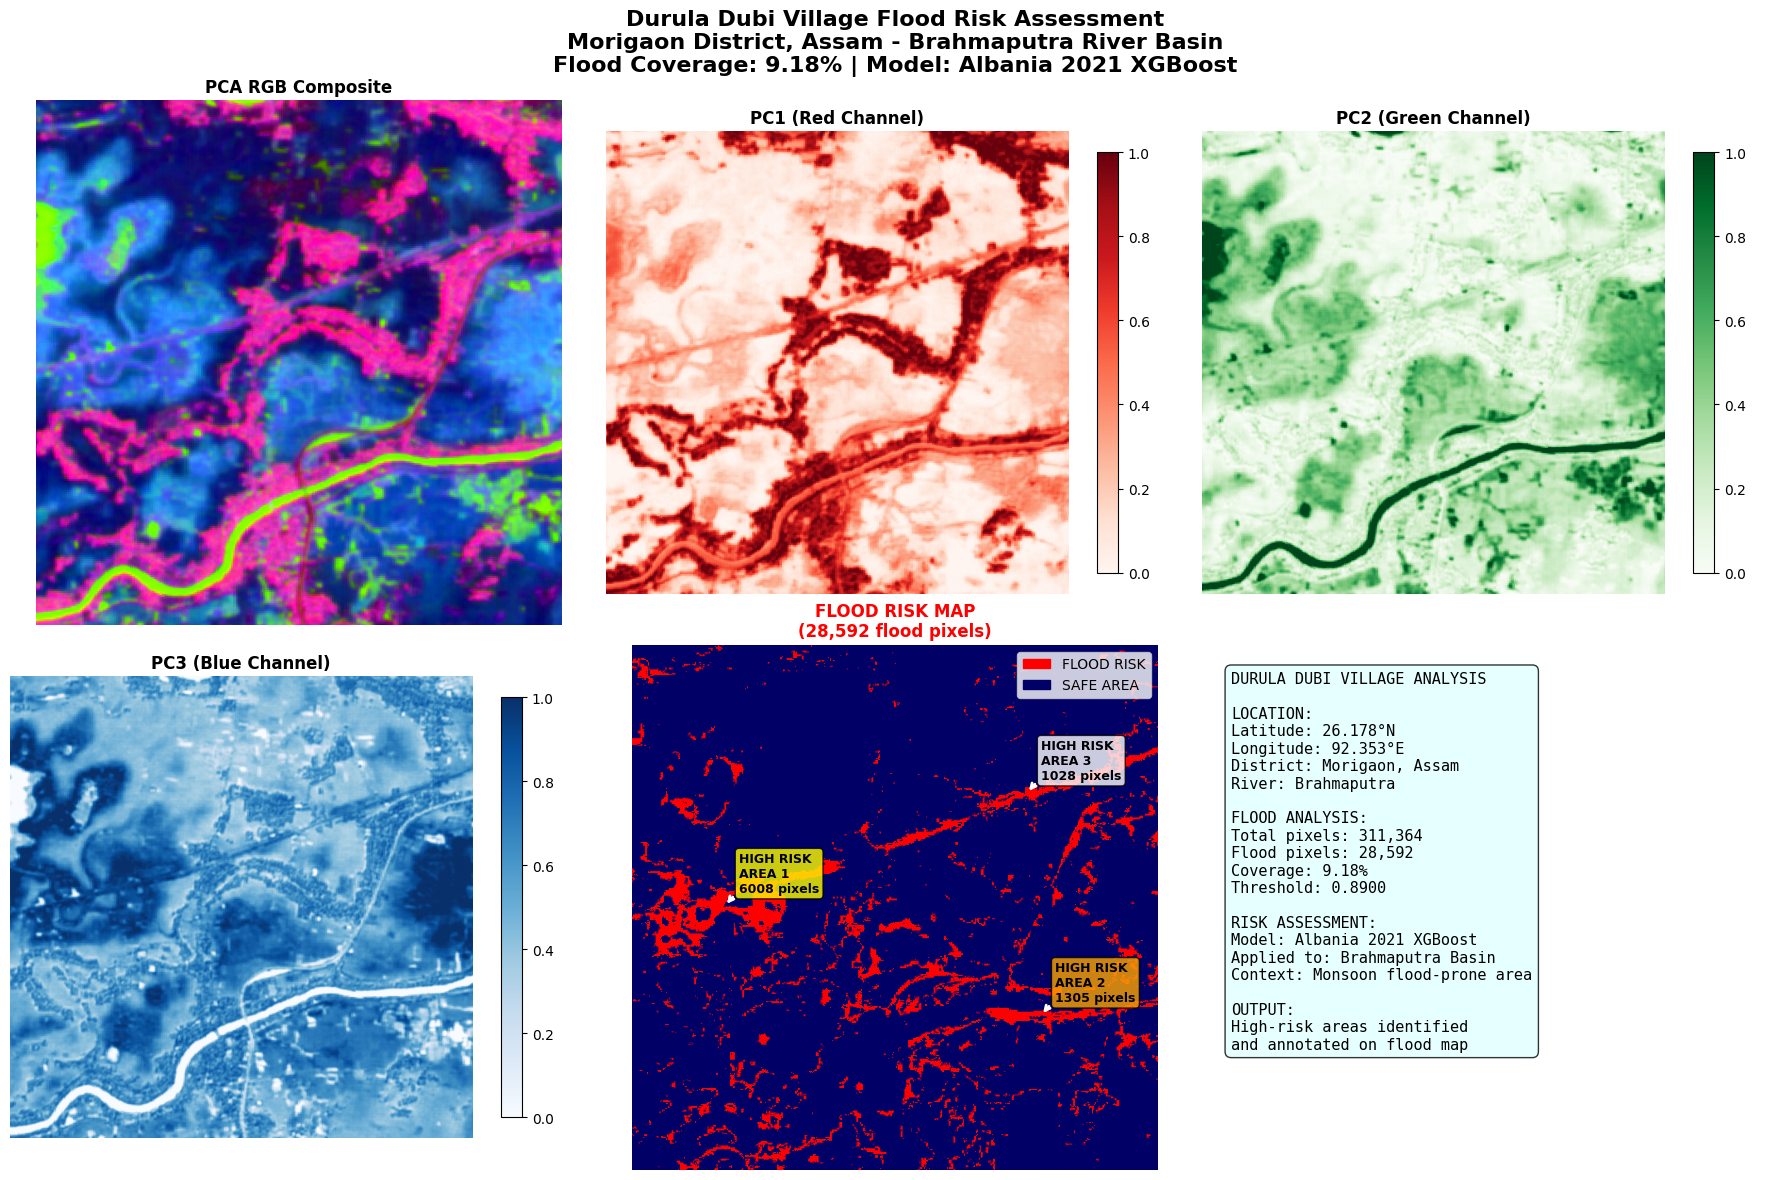

   ✅ Clean flood analysis: durula_dubi_flood_analysis_20250928_214218.png

💾 Saving flood prediction results...
   ✅ Probabilities: durula_dubi_flood_probabilities_20250928_214228.tif
   ✅ Flood mask: durula_dubi_flood_mask_20250928_214228.tif
   ✅ Assessment report: durula_dubi_flood_assessment_20250928_214228.txt

🎉 DURULA DUBI FLOOD PREDICTION COMPLETE!

🎯 FINAL ASSESSMENT:
   📍 Location: Durula Dubi Village, Morigaon, Assam
   🌊 Flood risk: 9.18% coverage
   ⚠️  Risk level: MODERATE
   📊 Decision threshold: 0.890000

💾 All results saved to: /content/drive/MyDrive/flood_predictions_durula_dubi_assam
🎨 High-contrast visualizations created for detailed analysis


In [10]:
import numpy as np
import rasterio
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from tqdm import tqdm
import gc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches

def predict_floods_durula_dubi(pca_rgb_path, model_path, chunk_size=50000):
    """
    Run flood predictions on Durula Dubi PCA RGB composite with high-contrast visualizations

    Parameters:
    - pca_rgb_path: Path to the PCA RGB TIFF file (3 bands)
    - model_path: Path to trained XGBoost model
    - chunk_size: Size of chunks for memory-efficient processing
    """

    print("🌊 DURULA DUBI FLOOD PREDICTION SYSTEM")
    print("📍 Morigaon District, Assam - Brahmaputra River")
    print("🎯 PCA RGB → Albania Model → High-Contrast Flood Maps")
    print("=" * 70)

    # Load model and threshold
    print("🤖 Loading Albania 2021 trained flood model...")
    try:
        model = joblib.load(model_path)
        print(f"   ✅ Model loaded: {os.path.basename(model_path)}")

        # Try to load optimal threshold
        results_path = model_path.replace('_model.joblib', '_results.joblib')
        if os.path.exists(results_path):
            results = joblib.load(results_path)
            optimal_threshold = results.get('optimal_threshold', 0.5)
            print(f"   ✅ Optimal threshold: {optimal_threshold:.6f}")
        else:
            print("   ⚠️  Using default threshold: 0.5")
            optimal_threshold = 0.5
    except Exception as e:
        print(f"   ❌ Error loading model: {e}")
        return None

    # Load PCA RGB composite
    print(f"\n📖 Loading PCA RGB composite...")
    try:
        with rasterio.open(pca_rgb_path) as src:
            print(f"   📏 Dimensions: {src.width} x {src.height}")
            print(f"   🎯 Bands: {src.count}")
            print(f"   🗺️  CRS: {src.crs}")
            print(f"   📦 Bounds: {src.bounds}")

            if src.count != 3:
                print(f"   ⚠️  Expected 3 PCA bands, got {src.count}")

            # Read PCA data: Shape (3, height, width)
            pca_data = src.read()
            profile = src.profile
            bands, height, width = pca_data.shape
            total_pixels = height * width

            print(f"   💾 PCA data shape: {pca_data.shape}")
            print(f"   📊 Total pixels: {total_pixels:,}")

            # Show PCA band statistics
            for i in range(bands):
                band_data = pca_data[i]
                valid_mask = ~np.isnan(band_data)
                if np.sum(valid_mask) > 0:
                    print(f"   📈 PC{i+1}: min={np.min(band_data[valid_mask]):.4f}, max={np.max(band_data[valid_mask]):.4f}")

    except Exception as e:
        print(f"   ❌ Error loading PCA RGB: {e}")
        return None

    # Prepare data for prediction
    print(f"\n🔄 Preparing PCA data for flood prediction...")

    # Reshape to (pixels, 3) for model input
    pca_reshaped = pca_data.reshape(bands, -1).T  # Shape: (pixels, 3)

    # Handle invalid pixels
    valid_mask = (~np.isnan(pca_reshaped).any(axis=1) &
                  ~np.isinf(pca_reshaped).any(axis=1))

    valid_data = pca_reshaped[valid_mask]
    valid_count = np.sum(valid_mask)

    print(f"   ✅ Valid pixels: {valid_count:,} / {total_pixels:,} ({valid_count/total_pixels*100:.1f}%)")

    if valid_count == 0:
        print("   ❌ No valid pixels found!")
        return None

    # Run flood predictions in chunks
    print(f"\n🌊 Running Albania model on Durula Dubi area...")
    n_chunks = (valid_count + chunk_size - 1) // chunk_size
    print(f"   🧩 Processing {valid_count:,} pixels in {n_chunks} chunks...")

    # Initialize prediction arrays
    flood_probabilities = np.full(total_pixels, np.nan, dtype=np.float32)
    flood_predictions = np.full(total_pixels, -1, dtype=np.int8)

    # Get valid pixel indices
    valid_indices = np.where(valid_mask)[0]

    # Process in chunks
    for i in tqdm(range(n_chunks), desc="   🎯 Predicting floods"):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, valid_count)

        chunk_indices = valid_indices[start_idx:end_idx]
        chunk_data = valid_data[start_idx:end_idx]

        try:
            # Get flood probabilities
            chunk_probs = model.predict_proba(chunk_data)[:, 1]
            chunk_binary = (chunk_probs >= optimal_threshold).astype(np.int8)

            # Store results
            flood_probabilities[chunk_indices] = chunk_probs
            flood_predictions[chunk_indices] = chunk_binary

        except Exception as e:
            print(f"❌ Error in chunk {i}: {e}")
            continue

        # Memory cleanup
        if i % 10 == 0:
            gc.collect()

    # Reshape results back to spatial dimensions
    prob_raster = flood_probabilities.reshape(height, width)
    binary_raster = flood_predictions.reshape(height, width)

    # Calculate prediction statistics
    valid_probs = flood_probabilities[valid_indices]
    valid_binary = flood_predictions[valid_indices]

    pred_flood_pixels = np.sum(valid_binary == 1)
    pred_flood_percentage = (pred_flood_pixels / valid_count) * 100

    print(f"\n📊 DURULA DUBI FLOOD ANALYSIS RESULTS:")
    print(f"   🌊 Flood pixels detected: {pred_flood_pixels:,} ({pred_flood_percentage:.2f}%)")
    print(f"   📈 Probability range: {np.min(valid_probs):.6f} - {np.max(valid_probs):.6f}")
    print(f"   📊 Mean flood probability: {np.mean(valid_probs):.6f}")
    print(f"   ⚠️  Risk level: {'🔴 VERY HIGH' if pred_flood_percentage > 20 else '🟠 HIGH' if pred_flood_percentage > 10 else '🟡 MODERATE' if pred_flood_percentage > 5 else '🟢 LOW'}")

    # Create high-contrast detailed visualizations
    print(f"\n🎨 Creating high-contrast flood visualizations...")
    create_high_contrast_flood_maps(pca_data, prob_raster, binary_raster,
                                   pca_rgb_path, optimal_threshold, pred_flood_percentage)

    # Save prediction results
    print(f"\n💾 Saving flood prediction results...")
    save_dir = os.path.dirname(pca_rgb_path)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save flood probability raster
    prob_output = os.path.join(save_dir, f"durula_dubi_flood_probabilities_{timestamp}.tif")
    prob_profile = profile.copy()
    prob_profile.update(dtype=rasterio.float32, count=1, compress='lzw')

    with rasterio.open(prob_output, 'w', **prob_profile) as dst:
        dst.write(prob_raster, 1)
        dst.descriptions = ['Flood Probability (Albania Model)']

    # Save binary flood mask
    binary_output = os.path.join(save_dir, f"durula_dubi_flood_mask_{timestamp}.tif")
    binary_profile = profile.copy()
    binary_profile.update(dtype=rasterio.int8, count=1, compress='lzw', nodata=-1)

    with rasterio.open(binary_output, 'w', **binary_profile) as dst:
        dst.write(binary_raster, 1)
        dst.descriptions = ['Binary Flood Mask (1=Flood, 0=No Flood, -1=NoData)']

    print(f"   ✅ Probabilities: {os.path.basename(prob_output)}")
    print(f"   ✅ Flood mask: {os.path.basename(binary_output)}")

    # Create comprehensive report
    report_output = os.path.join(save_dir, f"durula_dubi_flood_assessment_{timestamp}.txt")
    with open(report_output, 'w') as f:
        f.write("DURULA DUBI VILLAGE FLOOD RISK ASSESSMENT\n")
        f.write("Location: Morigaon District, Assam (Brahmaputra River)\n")
        f.write("Model: Albania 2021 Trained XGBoost\n")
        f.write("=" * 60 + "\n\n")

        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Input PCA RGB: {os.path.basename(pca_rgb_path)}\n")
        f.write(f"Model: {os.path.basename(model_path)}\n")
        f.write(f"Decision Threshold: {optimal_threshold:.6f}\n\n")

        f.write("STUDY AREA:\n")
        f.write("-" * 12 + "\n")
        f.write(f"Location: Durula Dubi Village (26.178°N, 92.353°E)\n")
        f.write(f"District: Morigaon, Assam, India\n")
        f.write(f"River: Brahmaputra\n")
        f.write(f"Context: Historically flood-prone area\n")
        f.write(f"Dimensions: {width} x {height} pixels\n")
        f.write(f"Total area pixels: {total_pixels:,}\n")
        f.write(f"Valid analysis pixels: {valid_count:,}\n\n")

        f.write("FLOOD PREDICTION RESULTS:\n")
        f.write("-" * 26 + "\n")
        f.write(f"Flood pixels predicted: {pred_flood_pixels:,}\n")
        f.write(f"Flood coverage: {pred_flood_percentage:.2f}%\n")
        f.write(f"Probability range: {np.min(valid_probs):.6f} - {np.max(valid_probs):.6f}\n")
        f.write(f"Mean probability: {np.mean(valid_probs):.6f}\n")

        risk_level = "VERY HIGH" if pred_flood_percentage > 20 else "HIGH" if pred_flood_percentage > 10 else "MODERATE" if pred_flood_percentage > 5 else "LOW"
        f.write(f"Risk Assessment: {risk_level}\n\n")

        f.write("OUTPUT FILES:\n")
        f.write("-" * 13 + "\n")
        f.write(f"Flood probabilities: {os.path.basename(prob_output)}\n")
        f.write(f"Binary flood mask: {os.path.basename(binary_output)}\n")
        f.write(f"Assessment report: {os.path.basename(report_output)}\n\n")

        f.write("INTERPRETATION:\n")
        f.write("-" * 15 + "\n")
        f.write("This analysis applies a flood prediction model trained on Albania 2021\n")
        f.write("satellite data to identify flood-prone areas in Durula Dubi village.\n")
        f.write("The village is located along the Brahmaputra River and experiences\n")
        f.write("regular flooding during monsoon seasons. Results should be used for:\n")
        f.write("- Early warning system development\n")
        f.write("- Evacuation planning\n")
        f.write("- Infrastructure protection measures\n")
        f.write("- Community preparedness initiatives\n")

    print(f"   ✅ Assessment report: {os.path.basename(report_output)}")

    print(f"\n🎉 DURULA DUBI FLOOD PREDICTION COMPLETE!")
    print("=" * 70)

    return {
        'probability_raster': prob_output,
        'binary_raster': binary_output,
        'report': report_output,
        'flood_percentage': pred_flood_percentage,
        'risk_level': risk_level,
        'threshold': optimal_threshold
    }

def create_high_contrast_flood_maps(pca_data, prob_raster, binary_raster,
                                   pca_path, threshold, flood_percentage):
    """Create simplified, clean flood visualizations"""

    try:
        # Create simplified figure layout
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Main title
        fig.suptitle('Durula Dubi Village Flood Risk Assessment\n' +
                    'Morigaon District, Assam - Brahmaputra River Basin\n' +
                    f'Flood Coverage: {flood_percentage:.2f}% | Model: Albania 2021 XGBoost',
                    fontsize=16, fontweight='bold')

        # 1. PCA RGB Composite
        rgb_display = np.zeros((pca_data.shape[1], pca_data.shape[2], 3))
        for i in range(3):
            band = pca_data[i]
            valid_mask = ~np.isnan(band)
            if np.sum(valid_mask) > 0:
                p1, p99 = np.percentile(band[valid_mask], [1, 99])
                rgb_display[:, :, i] = np.clip((band - p1) / (p99 - p1), 0, 1)

        axes[0,0].imshow(rgb_display)
        axes[0,0].set_title('PCA RGB Composite', fontsize=12, fontweight='bold')
        axes[0,0].axis('off')

        # 2. PC1 (Red Channel)
        pc1_norm = pca_data[0].copy()
        valid_mask = ~np.isnan(pc1_norm)
        if np.sum(valid_mask) > 0:
            p1, p99 = np.percentile(pc1_norm[valid_mask], [1, 99])
            pc1_norm = np.clip((pc1_norm - p1) / (p99 - p1), 0, 1)

        im1 = axes[0,1].imshow(pc1_norm, cmap='Reds', vmin=0, vmax=1)
        axes[0,1].set_title('PC1 (Red Channel)', fontsize=12, fontweight='bold')
        axes[0,1].axis('off')
        plt.colorbar(im1, ax=axes[0,1], shrink=0.8)

        # 3. PC2 (Green Channel)
        pc2_norm = pca_data[1].copy()
        valid_mask = ~np.isnan(pc2_norm)
        if np.sum(valid_mask) > 0:
            p1, p99 = np.percentile(pc2_norm[valid_mask], [1, 99])
            pc2_norm = np.clip((pc2_norm - p1) / (p99 - p1), 0, 1)

        im2 = axes[0,2].imshow(pc2_norm, cmap='Greens', vmin=0, vmax=1)
        axes[0,2].set_title('PC2 (Green Channel)', fontsize=12, fontweight='bold')
        axes[0,2].axis('off')
        plt.colorbar(im2, ax=axes[0,2], shrink=0.8)

        # 4. PC3 (Blue Channel)
        pc3_norm = pca_data[2].copy()
        valid_mask = ~np.isnan(pc3_norm)
        if np.sum(valid_mask) > 0:
            p1, p99 = np.percentile(pc3_norm[valid_mask], [1, 99])
            pc3_norm = np.clip((pc3_norm - p1) / (p99 - p1), 0, 1)

        im3 = axes[1,0].imshow(pc3_norm, cmap='Blues', vmin=0, vmax=1)
        axes[1,0].set_title('PC3 (Blue Channel)', fontsize=12, fontweight='bold')
        axes[1,0].axis('off')
        plt.colorbar(im3, ax=axes[1,0], shrink=0.8)

        # 5. Binary Flood Map with Annotations
        flood_display = np.full_like(binary_raster, np.nan, dtype=float)
        flood_display[binary_raster == 0] = 0  # No flood - dark blue
        flood_display[binary_raster == 1] = 1  # Flood - bright red

        flood_cmap = ListedColormap(['#000066', '#FF0000'])  # Dark blue, Bright red
        im_flood = axes[1,1].imshow(flood_display, cmap=flood_cmap, vmin=0, vmax=1)

        # Add annotations for high-risk regions
        # Find connected flood regions and annotate largest ones
        from scipy import ndimage
        flood_mask = binary_raster == 1
        if np.sum(flood_mask) > 0:
            # Label connected components
            labeled_floods, num_features = ndimage.label(flood_mask)

            # Find largest flood regions
            region_sizes = []
            for i in range(1, num_features + 1):
                region_size = np.sum(labeled_floods == i)
                region_sizes.append((region_size, i))

            # Sort by size and annotate top 3 largest regions
            region_sizes.sort(reverse=True)
            colors = ['yellow', 'orange', 'white']

            for idx, (size, label_id) in enumerate(region_sizes[:3]):
                if size > 50:  # Only annotate regions with >50 pixels
                    # Find centroid of the region
                    region_mask = labeled_floods == label_id
                    coords = np.where(region_mask)
                    center_y = int(np.mean(coords[0]))
                    center_x = int(np.mean(coords[1]))

                    # Add annotation
                    axes[1,1].annotate(f'HIGH RISK\nAREA {idx+1}\n{size} pixels',
                                      xy=(center_x, center_y),
                                      xytext=(10, 10), textcoords='offset points',
                                      bbox=dict(boxstyle='round,pad=0.3',
                                               facecolor=colors[idx],
                                               alpha=0.8),
                                      fontsize=9, fontweight='bold',
                                      arrowprops=dict(arrowstyle='->',
                                                    connectionstyle='arc3,rad=0.2',
                                                    color='white', lw=2))

        axes[1,1].set_title(f'FLOOD RISK MAP\n({np.sum(binary_raster==1):,} flood pixels)',
                           fontsize=12, fontweight='bold', color='red')
        axes[1,1].axis('off')

        # Custom legend for flood mask
        flood_patch = mpatches.Patch(color='#FF0000', label='FLOOD RISK')
        safe_patch = mpatches.Patch(color='#000066', label='SAFE AREA')
        axes[1,1].legend(handles=[flood_patch, safe_patch], loc='upper right', fontsize=10)

        # 6. Statistics Summary
        axes[1,2].axis('off')

        # Calculate statistics
        valid_pixels = np.sum(~np.isnan(prob_raster))
        flood_pixels = np.sum(binary_raster == 1)

        stats_text = f"""
DURULA DUBI VILLAGE ANALYSIS

LOCATION:
Latitude: 26.178°N
Longitude: 92.353°E
District: Morigaon, Assam
River: Brahmaputra

FLOOD ANALYSIS:
Total pixels: {valid_pixels:,}
Flood pixels: {flood_pixels:,}
Coverage: {flood_percentage:.2f}%
Threshold: {threshold:.4f}

RISK ASSESSMENT:
Model: Albania 2021 XGBoost
Applied to: Brahmaputra Basin
Context: Monsoon flood-prone area

OUTPUT:
High-risk areas identified
and annotated on flood map
        """

        axes[1,2].text(0.05, 0.95, stats_text.strip(), transform=axes[1,2].transAxes,
                      fontsize=11, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcyan", alpha=0.8))

        plt.tight_layout()

        # Save the visualization
        save_dir = os.path.dirname(pca_path)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_output = os.path.join(save_dir, f"durula_dubi_flood_analysis_{timestamp}.png")

        plt.savefig(plot_output, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()

        print(f"   ✅ Clean flood analysis: {os.path.basename(plot_output)}")

    except Exception as e:
        print(f"   ⚠️  Visualization error: {e}")

def main():
    """Main execution for Durula Dubi flood prediction"""

    # File paths
    pca_rgb_path = "/content/drive/MyDrive/flood_predictions_durula_dubi_assam/durula_dubi_PCA_RGB_20250928_212039.tif"
    model_path = "/content/drive/MyDrive/XGBoost_Flood_Models/Albania_2021_20250927_212646_optimized_xgboost_20250928_011003_model.joblib"

    # Verify files exist
    if not os.path.exists(pca_rgb_path):
        print(f"❌ PCA RGB file not found: {pca_rgb_path}")
        return

    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        return

    print(f"📁 Input files verified:")
    print(f"   🛰️  PCA RGB: {os.path.basename(pca_rgb_path)}")
    print(f"   🤖 Model: {os.path.basename(model_path)}")

    # Run flood prediction
    results = predict_floods_durula_dubi(
        pca_rgb_path=pca_rgb_path,
        model_path=model_path,
        chunk_size=50000
    )

    if results:
        print(f"\n🎯 FINAL ASSESSMENT:")
        print(f"   📍 Location: Durula Dubi Village, Morigaon, Assam")
        print(f"   🌊 Flood risk: {results['flood_percentage']:.2f}% coverage")
        print(f"   ⚠️  Risk level: {results['risk_level']}")
        print(f"   📊 Decision threshold: {results['threshold']:.6f}")
        print(f"\n💾 All results saved to: {os.path.dirname(pca_rgb_path)}")
        print(f"🎨 High-contrast visualizations created for detailed analysis")

if __name__ == "__main__":
    main()